In [75]:
# Importamos librerias
import torch
import torch.nn as nn
from torch.nn import functional as F
from IPython.display import Image, display

In [76]:
# Comprobamos la versión de PyTorch
print(f"PyTorch version: {torch.__version__}")

# Comprobamos si CUDA está disponible
cuda_available = torch.cuda.is_available()

# Comprobamos si MPS (Metal Performance Shader) está disponible
mps_available = torch.backends.mps.is_available()

# Selección del dispositivo
if cuda_available:
    device = "cuda"
elif mps_available:
    device = "mps"
else:
    device = "cpu"

# Mostramos información
print(f"CUDA available: {cuda_available}")
print(f"MPS available: {mps_available}")
print(f"Using device: {device}")


PyTorch version: 2.1.2
CUDA available: False
MPS available: True
Using device: mps


In [77]:
# Variables

# Tamaño del bloque de datos en el procesamiento
block_size = 8  

# Número de muestras a procesar en un lote
batch_size = 4

# Tasa de aprendizaje
learning_rate = 3e-4

# Frecuencia de evaluación durante el entrenamiento
eval_iters = 250

# Número máximo de iteraciones de entrenamiento
max_iters = 10000

# Tasa de dropout
dropout = 0.2

# Dispositivo (GPU o CPU) para usar con torch.tensor
device = torch.device(device)


# Variables

### `block_size`

#### Qué es
El `block_size` se refiere a la cantidad de elementos (como caracteres) que el modelo procesa en una sola secuencia de datos.

#### Profundizando
En el contexto de los modelos de lenguaje, `block_size` juega un papel crucial al determinar la longitud de las secuencias de texto que el modelo puede observar y aprender a la vez. Un `block_size` más grande permite al modelo comprender mejor el contexto y las relaciones entre partes más distantes del texto. Sin embargo, esto también puede hacer que el entrenamiento del modelo sea más complejo y requiera más recursos computacionales.

#### Ejemplo
Imagina que tienes el texto "Hola mundo, bienvenidos a la inteligencia artificial". Si `block_size` es 5, el modelo procesaría este texto fragmentado en secuencias de 5 caracteres cada una, como "Hola ", "mundo", y así sucesivamente.

---

### `batch_size`

#### Qué es
El `batch_size` se refiere al número de secuencias de datos que el modelo procesa en conjunto durante un solo paso de entrenamiento.

#### Profundizando
La elección del `batch_size` tiene un impacto directo en cómo el modelo aprende de los datos. Un `batch_size` más grande permite que el modelo aprenda de más ejemplos en cada paso de entrenamiento, lo que puede hacer que el proceso de aprendizaje sea más estable y eficiente. Sin embargo, un `batch_size` mayor también implica un mayor consumo de memoria y capacidad de procesamiento, lo que puede ser un desafío en términos de recursos computacionales.

#### Ejemplo
Siguiendo con el ejemplo anterior, si `batch_size` es 2 y `block_size` es 5, en cada paso de entrenamiento, el modelo procesaría dos secuencias de 5 caracteres cada una. Por ejemplo, podría procesar "Hola " y "mundo" juntos en un paso, y luego " bien" y "venid" en el siguiente.

---

### `learning_rate`

#### Qué es
La `learning_rate` (tasa de aprendizaje) determina la magnitud de los ajustes realizados en los parámetros del modelo durante el entrenamiento.

#### Profundizando
Una `learning_rate` más alta permite ajustes más grandes en cada paso de entrenamiento, lo que puede acelerar la convergencia, pero también corre el riesgo de saltar por encima del óptimo. Una `learning_rate` más baja hace que los ajustes sean más pequeños y estables, pero puede hacer que el entrenamiento sea más lento. En general, encontrar la `learning_rate` adecuada es una parte crucial del ajuste de hiperparámetros.

#### Ejemplo
Supongamos que la `learning_rate` es 0.001. Esto significa que durante cada paso de entrenamiento, los parámetros del modelo se ajustarán en una magnitud proporcional a 0.001 veces el gradiente del error.

---

### `eval_iters`

#### Qué es
`eval_iters` representa la frecuencia con la que se evalúa el modelo durante el entrenamiento.

#### Profundizando
Durante el entrenamiento, es importante realizar evaluaciones periódicas del modelo en un conjunto de validación para monitorear su rendimiento. `eval_iters` determina cada cuántas iteraciones de entrenamiento se llevará a cabo esta evaluación.

#### Ejemplo
Si `eval_iters` es 250, significa que el modelo se evaluará cada 250 iteraciones de entrenamiento para medir su rendimiento en un conjunto de validación.

---

### `max_iters`

#### Qué es
`max_iters` representa el número máximo de iteraciones de entrenamiento que se llevarán a cabo.

#### Profundizando
Limitar el número de iteraciones de entrenamiento puede ser útil para evitar que el modelo se entrene durante demasiado tiempo y posiblemente sobreajuste los datos de entrenamiento.

#### Ejemplo
Si `max_iters` es 10000, el entrenamiento se detendrá después de 10000 iteraciones, independientemente de si se ha alcanzado la convergencia.

---

### `dropout`

#### Qué es
`dropout` es una técnica de regularización que se utiliza durante el entrenamiento para evitar el sobreajuste del modelo.

#### Profundizando
El `dropout` implica desactivar aleatoriamente una fracción de las unidades (neuronas) en una capa durante cada paso de entrenamiento. Esto evita que el modelo se vuelva demasiado dependiente de ciertas conexiones y mejora su capacidad de generalización.

#### Ejemplo
Si `dropout` es 0.2, significa que aproximadamente el 20% de las unidades en cada capa se desactivarán aleatoriamente durante el entrenamiento.

---

### `device`

#### Qué es
`device` especifica si el modelo se ejecutará en una unidad de procesamiento gráfico (GPU) o en la unidad central de procesamiento (CPU).

#### Profundizando
El uso de una GPU puede acelerar significativamente el entrenamiento de modelos de aprendizaje profundo debido a su capacidad de procesamiento paralelo. Sin embargo, la elección de la GPU o la CPU depende de la disponibilidad de hardware y recursos.

#### Ejemplo
Si `device` está configurado para utilizar una GPU, el modelo se ejecutará en la GPU para aprovechar su potencia de cálculo. Si se establece en CPU, el modelo se ejecutará en la CPU.



In [78]:
# Abrir el archivo de texto y leer su contenido
with open('wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Crear una lista de caracteres únicos en el texto y calcular el tamaño del vocabulario
chars = sorted(set(text))
vocab_size = len(chars)

# Imprimir una vista previa del texto, la lista de caracteres únicos y el número total de caracteres diferentes
print('Vista previa del texto:', text[:500])  # Muestra los primeros 2000 caracteres del texto
print('Lista de caracteres únicos:', chars)    # Muestra los caracteres únicos encontrados en el texto
print('Número total de caracteres diferentes:', vocab_size)  # Muestra el número total de caracteres diferentes

Vista previa del texto: ﻿The Wonderful Wizard of Oz




Chapter I
The Cyclone


Dorothy lived in the midst of the great Kansas prairies, with Uncle
Henry, who was a farmer, and Aunt Em, who was the farmer’s wife. Their
house was small, for the lumber to build it had to be carried by wagon
many miles. There were four walls, a floor and a roof, which made one
room; and this room contained a rusty looking cookstove, a cupboard for
the dishes, a table, three or four chairs, and the beds. Uncle Henry
and Aunt Em had a big b
Lista de caracteres únicos: ['\n', ' ', '!', '(', ')', ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '—', '‘', '’', '“', '”', '\ufeff']
Número total de caracteres diferentes: 69


In [79]:
# Establecemos el encoder y el decoder

# Crear un diccionario para convertir caracteres a números (índices)
string_to_int = { ch:i for i,ch in enumerate(chars) }

# Crear un diccionario para convertir números (índices) de vuelta a caracteres
int_to_string = { i:ch for i,ch in enumerate(chars) }

# Definir una función de codificación que convierte una cadena de texto en una lista de índices
encode = lambda s: [string_to_int[c] for c in s]

# Definir una función de decodificación que convierte una lista de índices de vuelta a una cadena de texto
decode = lambda l: ''.join([int_to_string[i] for i in l])

## Explicación del Encoder y Decoder

El código establece dos diccionarios y dos funciones para convertir entre caracteres y sus representaciones numéricas (índices).

### Diccionarios de Codificación y Decodificación
- `string_to_int`: Este diccionario convierte cada carácter en un número único (índice). Se utiliza para "codificar" un texto, cambiando cada carácter por su correspondiente índice.
- `int_to_string`: Este diccionario hace lo opuesto, convierte cada índice numérico de vuelta a su carácter correspondiente. Se utiliza para "decodificar" una secuencia de índices, reconstruyendo el texto original.

### Funciones de Codificación y Decodificación
- `encode`: Esta función toma una cadena de texto y devuelve una lista de índices. Por ejemplo, si `string_to_int` mapea 'a' a 0 y 'b' a 1, entonces `encode("ab")` devolverá `[0, 1]`.
- `decode`: Esta función hace lo contrario de `encode`. Toma una lista de índices y devuelve una cadena de texto. Por ejemplo, si `int_to_string` mapea 0 a 'a' y 1 a 'b', entonces `decode([0, 1])` devolverá `"ab"`.

### Ejemplo
Supongamos que `chars` contiene ['a', 'b', 'c'].
- `string_to_int` sería `{ 'a': 0, 'b': 1, 'c': 2 }`.
- `int_to_string` sería `{ 0: 'a', 1: 'b', 2: 'c' }`.
- Al codificar `"abc"`, `encode` devolvería `[0, 1, 2]`.
- Al decodificar `[0, 1, 2]`, `decode` devolvería `"abc"`.


In [80]:
# Convertir el texto codificado en un tensor de PyTorch
data = torch.tensor(encode(text), dtype = torch.long)

# Imprimir los primeros 100 elementos del tensor para inspección
print('Texto a tensor: ', data[:100])

Texto a tensor:  tensor([68, 30, 44, 41,  1, 33, 51, 50, 40, 41, 54, 42, 57, 48,  1, 33, 45, 62,
        37, 54, 40,  1, 51, 42,  1, 25, 62,  0,  0,  0,  0,  0, 13, 44, 37, 52,
        56, 41, 54,  1, 19,  0, 30, 44, 41,  1, 13, 61, 39, 48, 51, 50, 41,  0,
         0,  0, 14, 51, 54, 51, 56, 44, 61,  1, 48, 45, 58, 41, 40,  1, 45, 50,
         1, 56, 44, 41,  1, 49, 45, 40, 55, 56,  1, 51, 42,  1, 56, 44, 41,  1,
        43, 54, 41, 37, 56,  1, 21, 37, 50, 55])


### Definición de un Torch Tensor

#### Qué es
Un tensor de PyTorch es una colección de números, similar a una lista o un array, pero con capacidades adicionales para realizar cálculos rápidos y compatibilidad con aprendizaje automático.

#### Profundizando
Un tensor en PyTorch es una estructura de datos multidimensional que es fundamental en la biblioteca PyTorch para el cálculo numérico. Está optimizado para realizar operaciones rápidas, tanto en CPU como en GPU, lo que es esencial para el entrenamiento y ejecución de modelos de aprendizaje automático. Los tensores pueden almacenar datos en diferentes tipos (como flotantes, enteros) y en múltiples dimensiones (1D, 2D, 3D, etc.).

#### Ejemplo
- **Creación de un Tensor:** Supongamos que tienes una lista de números `[1, 2, 3]`. Al aplicar `torch.tensor([1, 2, 3])`, esta lista se convierte en un tensor de PyTorch.
- **Tipo de Tensor:** Si especificas `dtype=torch.long`, estás indicando que los números en el tensor deben ser enteros de 64 bits. Por ejemplo, `torch.tensor([1, 2, 3], dtype=torch.long)`.


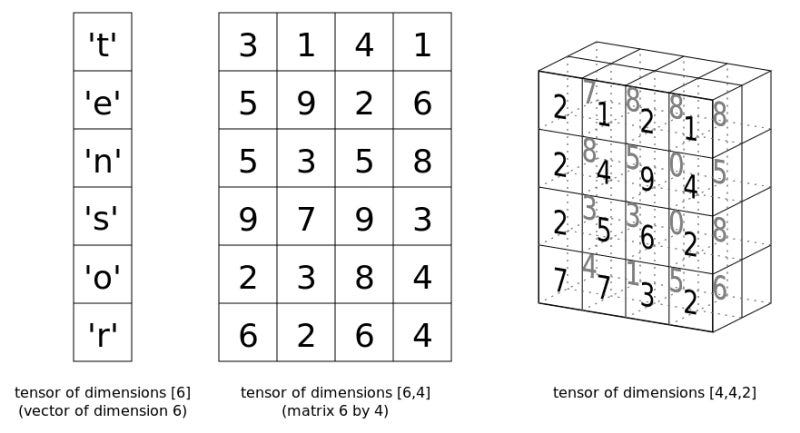

In [81]:
# Ejemplo
display(Image(filename='../Images/tensor.jpeg'))

In [82]:
# Separamos el tensor en datos de entrenamiento y validación

# Calcular el número de datos para el conjunto de entrenamiento (80% del total)
n = int(0.8 * len(data))

# Separar los datos de entrenamiento (primer 80% del tensor)
train_data = data[:n]

# Separar los datos de validación (último 20% del tensor)
val_data = data[n:]

In [83]:
# Preparación de secuencias iniciales para entender 'block_size'
x = train_data[:block_size]  # Tomar los primeros 'block_size' elementos para inputs
y = train_data[1:block_size + 1]  # Tomar los elementos de 1 a 'block_size + 1' para targets

# Iterar sobre el rango de 'block_size' para mostrar contexto y objetivo
for t in range(block_size):
    context = x[:t + 1]  # Contexto: secuencia de entrada hasta el índice actual
    target = y[t]        # Objetivo: elemento correspondiente en 'y'
    print('when input is ', context, 'target is ', target)  # Imprimir contexto y objetivo


when input is  tensor([68]) target is  tensor(30)
when input is  tensor([68, 30]) target is  tensor(44)
when input is  tensor([68, 30, 44]) target is  tensor(41)
when input is  tensor([68, 30, 44, 41]) target is  tensor(1)
when input is  tensor([68, 30, 44, 41,  1]) target is  tensor(33)
when input is  tensor([68, 30, 44, 41,  1, 33]) target is  tensor(51)
when input is  tensor([68, 30, 44, 41,  1, 33, 51]) target is  tensor(50)
when input is  tensor([68, 30, 44, 41,  1, 33, 51, 50]) target is  tensor(40)


In [84]:
def get_batch(split):
    """
    Genera un lote de datos para entrenamiento o validación.
    
    Args:
    split (str): 'train' para datos de entrenamiento, 'val' para datos de validación.

    Returns:
    tuple: Dos tensores, 'x' para inputs y 'y' para targets.
    """
    # Elegir los datos de entrenamiento o validación
    data = train_data if split == 'train' else val_data

    # Escoger índices al azar para empezar a tomar datos
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # Juntar los datos de entrada (x) a partir de los índices
    x = torch.stack([data[i:i+block_size] for i in ix])

    # Juntar los datos objetivo (y), que están un paso adelante de x
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    # Mover x y y al dispositivo (como una GPU)
    x, y = x.to(device), y.to(device)

    return x, y

# Ejemplo de uso
x, y = get_batch('train')
print('inputs:')
print(x)
print('targets:')
print(y)

inputs:
tensor([[59, 37, 61,  1, 42, 54, 51, 49],
        [56,  1, 61, 51, 57,  1, 54, 57],
        [30, 51, 56, 51,  0, 42, 51, 48],
        [ 1, 50, 51,  5, 67,  1, 40, 41]], device='mps:0')
targets:
tensor([[37, 61,  1, 42, 54, 51, 49,  1],
        [ 1, 61, 51, 57,  1, 54, 57, 50],
        [51, 56, 51,  0, 42, 51, 48, 48],
        [50, 51,  5, 67,  1, 40, 41, 39]], device='mps:0')


## Explicación Simple de la Función `get_batch`

La función `get_batch` prepara datos para entrenar o probar el modelo. 

### ¿Qué Hace?
- Elige si usar datos de entrenamiento o de validación.
- Crea dos grupos de datos: `x` (datos de entrada) y `y` (objetivos a predecir).

### ¿Cómo Funciona?
1. **Elección de Datos:** Según si necesitas datos de entrenamiento (`'train'`) o validación (`'val'`), la función elige el conjunto de datos correspondiente.
2. **Índices Aleatorios:** Escoge puntos aleatorios desde donde tomará secuencias de datos.
3. **Creación de `x`:** Recoge secuencias de datos desde esos puntos. Estas secuencias son lo que el modelo intentará aprender.
4. **Creación de `y`:** Recoge las secuencias que están justo después de las de `x`. Estas son las 'respuestas' que el modelo debe aprender a predecir.
5. **Preparación para el Modelo:** Los datos se preparan para ser procesados por el modelo (en una GPU, por ejemplo).

### Ejemplo
- Si `block_size` es 10 y `batch_size` es 2, la función tomará dos secuencias de 10 elementos del texto.
- `x` podría ser ["Hola mundo", "¿Cómo est"], y `y` sería ["ola mundo ", "Cómo estás"], que es lo que sigue inmediatamente en el texto.
- Estos datos se usan para entrenar el modelo, enseñándole a predecir la siguiente parte del texto.

In [85]:
@torch.no_grad()  # Desactivar el cálculo de gradientes para reducir uso de memoria y acelerar
def estimate_loss():
    """
    Estima la pérdida del modelo en los conjuntos de datos de entrenamiento y validación.
    
    Returns:
    dict: Un diccionario con las pérdidas promedio de 'train' y 'val'.
    """
    out = {}  # Diccionario para almacenar las pérdidas promedio
    model.eval()  # Poner el modelo en modo evaluación

    # Evaluar pérdida en ambos conjuntos de datos
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)  # Tensor para almacenar las pérdidas

        # Calcular pérdida para cada iteración
        for k in range(eval_iters):
            X, Y = get_batch(split)  # Obtener lote de datos
            logits, loss = model(X, Y)  # Calcular la salida y la pérdida del modelo
            losses[k] = loss.item()  # Guardar la pérdida de la iteración actual

        out[split] = losses.mean()  # Calcular y almacenar la pérdida media

    model.train()  # Poner el modelo de vuelta en modo entrenamiento
    return out  # Devolver las pérdidas promedio

## Explicación Simple de la Función `estimate_loss`

Esta función estima cuán bien está funcionando el modelo, calculando su pérdida (error) en los datos de entrenamiento y validación.

### ¿Qué Hace?
- Calcula la pérdida media del modelo, tanto en el entrenamiento como en la validación.

### ¿Cómo Funciona?
1. **Preparación:** Desactiva el cálculo de gradientes, lo que es útil para ahorrar memoria y acelerar el proceso ya que no estamos entrenando el modelo aquí.
2. **Modo de Evaluación:** Cambia el modelo a modo de evaluación, adecuado para probar su rendimiento.
3. **Cálculo de Pérdidas:**
    - Itera sobre los conjuntos de entrenamiento (`'train'`) y validación (`'val'`).
    - Para cada uno, calcula la pérdida en varias iteraciones (`eval_iters`).
    - En cada iteración, obtiene un lote de datos y calcula la pérdida del modelo en esos datos.
    - Guarda todas estas pérdidas y calcula su media.
4. **Resultados:** Almacena la pérdida media de cada conjunto ('train' y 'val') en un diccionario y lo devuelve.
5. **Volver al Modo de Entrenamiento:** Cambia el modelo de vuelta a modo de entrenamiento.

### Ejemplo
- Si `eval_iters` es 10, la función calcula la pérdida del modelo 10 veces para cada conjunto de datos.
- Por ejemplo, si las pérdidas de entrenamiento son [0.5, 0.6, 0.4, ...] y las de validación [0.7, 0.8, 0.6, ...], calcula y devuelve la media de estos valores para cada conjunto.


In [86]:
# Definimos nuestra clase BigramLanguageModel, que es un tipo de red neuronal.
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        """
        Constructor de la clase BigramLanguageModel.

        Args:
        - vocab_size (int): Tamaño del vocabulario.
        """
        # Llamamos al constructor de la clase padre nn.Module.
        super().__init__()
        # Creamos una tabla de embeddings, que es como un diccionario donde cada
        # carácter (representado como un índice único) se mapea a un vector de números.
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        
    def forward(self, index, targets=None):
        """
        Definición de la función forward.

        Args:
        - index (tensor): Índices de caracteres de entrada.
        - targets (tensor, opcional): Índices de caracteres objetivo para calcular la pérdida.

        Returns:
        - logits (tensor): Resultado de la red.
        - loss (tensor, opcional): Pérdida calculada si se proporcionan los objetivos.
        """
        # Obtenemos los embeddings de los índices de los caracteres proporcionados.
        logits = self.token_embedding_table(index)
        
        # Si no se proporcionan 'targets', no calculamos la pérdida.
        if targets is None:
            loss = None
        else:
            # Redimensionamos los logits y los 'targets' para calcular la pérdida.
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # Calculamos la pérdida de entropía cruzada entre los logits y los targets.
            loss = F.cross_entropy(logits, targets)
        
        # Retornamos tanto los logits como la pérdida (si se calculó).
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        """
        Genera una secuencia de texto basada en el modelo.

        Args:
        - index (tensor): Índices de caracteres de inicio.
        - max_new_tokens (int): Número máximo de nuevos caracteres a generar.

        Returns:
        - generated_sequence (tensor): Secuencia de índices generada.
        """
        # index es un tensor de índices que representa el contexto actual de caracteres.
        for _ in range(max_new_tokens):
            # Obtenemos las predicciones del modelo llamando a forward.
            logits, _ = self.forward(index)
            # Nos enfocamos solo en el último paso de tiempo de los logits.
            logits = logits[:, -1, :]
            # Aplicamos la función softmax para obtener una distribución de probabilidad.
            probs = F.softmax(logits, dim=-1)
            # Muestreamos un nuevo índice de carácter de esa distribución.
            index_next = torch.multinomial(probs, num_samples=1)
            # Añadimos el índice del nuevo carácter al final de la secuencia de índices.
            index = torch.cat((index, index_next), dim=1)
        # Retornamos la secuencia completa de índices generados.
        return index

# Crear una instancia del modelo
model = BigramLanguageModel(vocab_size)
m = model.to(device)

# context es el tensor que contiene el índice de inicio para la generación de texto.
context = torch.zeros((1,1), dtype=torch.long, device=device)



### Repaso Sobre Clases en Python y Conceptos Relacionados

Las clases en Python son una parte fundamental de la programación orientada a objetos (POO). Te permiten crear tus propios tipos de datos personalizados agrupando variables y funciones. Aquí hay un repaso de algunos conceptos clave usando tu código como ejemplo.

#### Qué es una Clase
- **Definición Sencilla:** Una clase en Python es como un 'molde' para crear objetos. Cada objeto creado a partir de una clase se llama instancia de esa clase.
- **En tu Código:** La clase `BigramLanguageModel` es un molde para crear modelos de lenguaje de bigramas.

#### Método `__init__` y `super().__init__()`
- **Definición de `__init__`:** Este método se llama automáticamente cuando creas una nueva instancia de una clase. Se usa para inicializar los atributos del objeto.
- **`super().__init__()`:** Esta línea llama al método `__init__` de la clase padre (`nn.Module` en tu caso). Es necesario para que PyTorch configure correctamente tu modelo como una subclase de `nn.Module`.
- **En tu Código:** Cuando creas un objeto `BigramLanguageModel`, `__init__` configura tu modelo con todo lo que necesita para empezar, como la tabla de embeddings.

#### `self`
- **Definición Sencilla:** `self` se refiere al objeto actual. Se utiliza para acceder a variables y métodos del objeto.
- **En tu Código:** Dentro de `BigramLanguageModel`, usas `self` para referirte a atributos y métodos específicos de esa instancia del modelo, como `self.token_embedding_table`.

#### Ejemplo Adaptado a tu Código
- **Creación de una Clase:** La clase `BigramLanguageModel` define cómo es un modelo de lenguaje de bigramas, incluyendo cómo se inicializa (`__init__`) y cómo procesa datos (`forward` y `generate`).
- **Inicialización y Herencia:** Al llamar a `BigramLanguageModel(vocab_size)`, se inicializa un modelo con un tamaño de vocabulario específico y se configura correctamente como una subclase de `nn.Module` gracias a `super().__init__()`.

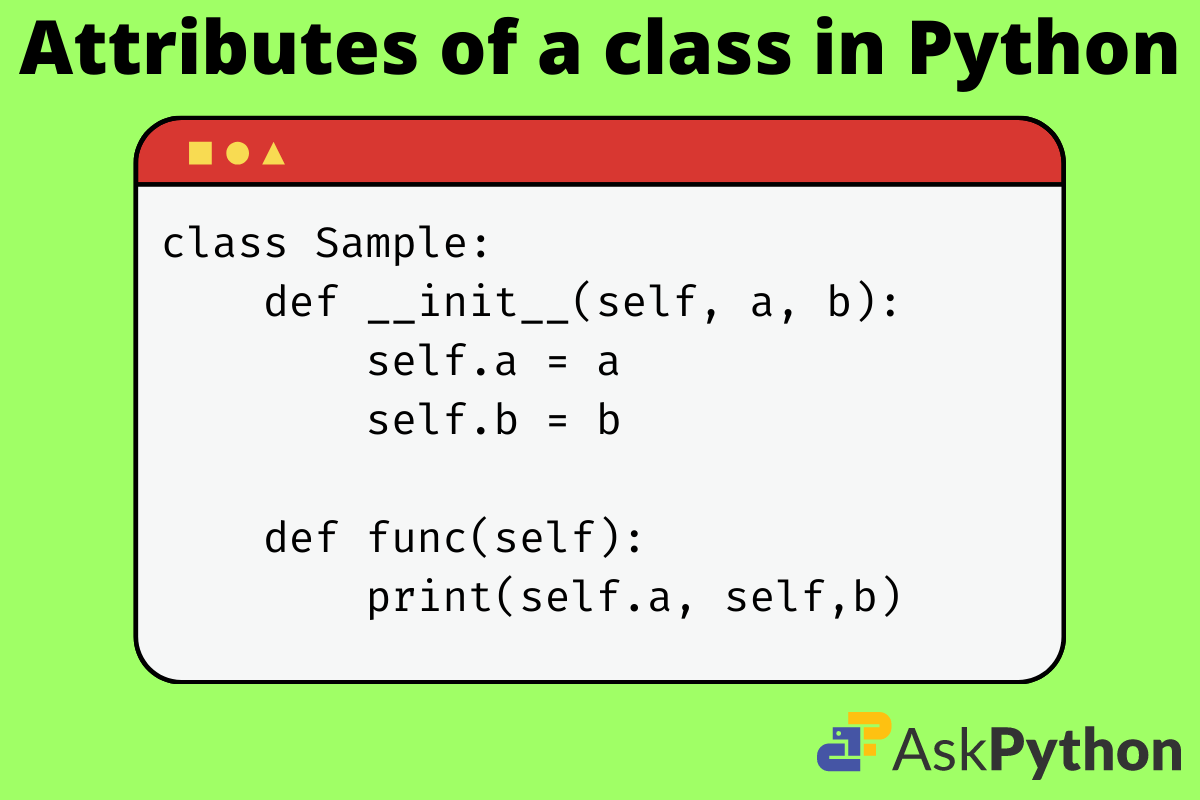

In [87]:
# Ejemplo
display(Image(filename='../Images/python_class.png'))

### Tabla de Embeddings en PyTorch

En PyTorch, una tabla de embeddings es una estructura fundamental utilizada en modelos de lenguaje y procesamiento de texto. Representa una asignación de índices (como enteros) a vectores de números (los embeddings). La línea `self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)` define una tabla de embeddings en la clase `BigramLanguageModel`.

#### Explicación Sencilla:
- Una tabla de embeddings es como un diccionario que asigna índices únicos (en este caso, representando caracteres) a vectores numéricos.
- `vocab_size` representa el tamaño del vocabulario, es decir, cuántos caracteres diferentes se incluyen en la tabla.
- Cada índice (carácter) se asigna a un vector de números de la misma dimensión, que se utiliza para representar ese carácter en el modelo.

#### Explicación Profunda:
- La línea `nn.Embedding(vocab_size, vocab_size)` crea una tabla de embeddings con `vocab_size` filas y `vocab_size` columnas.
- Conceptualmente, cada fila de la tabla representa un carácter único y se asocia con un vector numérico (embedding) de `vocab_size` dimensiones.
- Durante la ejecución del modelo, los índices de caracteres se utilizan para acceder a las filas correspondientes de esta tabla y obtener los embeddings de caracteres.
- Estos embeddings se utilizan para alimentar las capas de la red neuronal y realizar predicciones basadas en el contexto.

#### Ejemplo Detallado:
- Supongamos que `vocab_size` es 100 y tenemos un carácter 'a' que se representa con el índice 5.
- La tabla de embeddings tendrá 100 filas y 100 columnas.
- El índice 5 se utilizará para acceder a la fila 5 de la tabla, que contiene un vector de 100 números.
- Este vector de números (embedding) representa el carácter 'a' y se utiliza en el modelo para generar predicciones basadas en el contexto.

En resumen, una tabla de embeddings es una parte esencial de un modelo de lenguaje y se utiliza para convertir índices de caracteres en vectores numéricos que la red neuronal puede procesar.


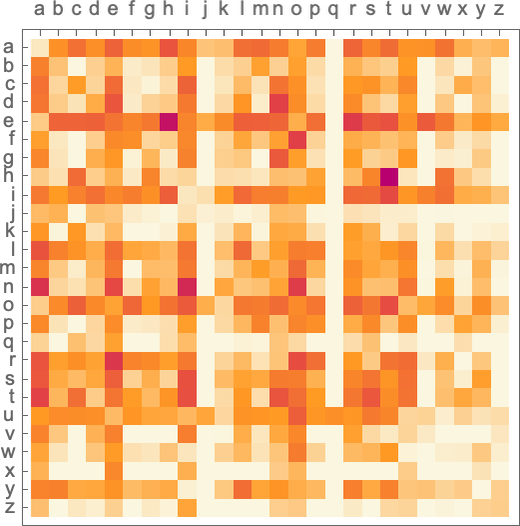

In [88]:
# Ejemplo
display(Image(filename='../Images/Embeddings_table.png'))


### Función `forward` en la Clase `BigramLanguageModel`

La función `forward` es fundamental en la clase `BigramLanguageModel`, que representa un modelo de lenguaje basado en bigramas.

#### Explicación Sencilla:
- La función `forward` toma dos argumentos principales: `index` y `targets` (opcional).
- `index` son los índices de los caracteres de entrada que se utilizan como contexto para generar predicciones.
- Si se proporcionan `targets`, la función también calcula la pérdida, que mide la diferencia entre las predicciones y los objetivos.
- Las predicciones (logits) se obtienen a partir de los embeddings de caracteres y representan la probabilidad de los siguientes caracteres dados los caracteres del contexto.

#### Explicación Profunda:
- `index` es un tensor que contiene índices de caracteres utilizados como contexto para la generación de texto.
- En la función, se obtienen embeddings de caracteres correspondientes a los índices de `index`.
- Estos embeddings se utilizan para generar predicciones, que son distribuciones de probabilidad de los caracteres siguientes en función del contexto.
- Si se proporcionan `targets`, los logits se redimensionan y se calcula la pérdida de entropía cruzada entre los logits y los objetivos para entrenar el modelo.
- En resumen, esta función define cómo los datos fluyen a través de la red y se utilizan para hacer predicciones.

#### Ejemplo Paso por Paso:
- Supongamos que `index` contiene `[0, 3, 7]`, lo que significa que los índices de los caracteres de entrada son 0, 3 y 7.
- Se obtienen embeddings correspondientes a estos índices.
- Luego, se generan predicciones basadas en estos embeddings, que representan las probabilidades de los siguientes caracteres dados los caracteres de contexto.
- Si se proporcionan `targets`, se calcula la pérdida para entrenar el modelo.

Esta función es esencial para la generación de predicciones y el entrenamiento del modelo de lenguaje.


### Función `generate` en la Clase `BigramLanguageModel`

La función `generate` desempeña un papel crucial en la clase `BigramLanguageModel`, que representa un modelo de lenguaje basado en bigramas.

#### Explicación Sencilla:
- La función `generate` se utiliza para generar secuencias de texto basadas en el modelo.
- Recibe dos argumentos principales: `index`, que es el contexto inicial de caracteres, y `max_new_tokens`, que determina cuántos nuevos caracteres se generarán.
- Itera para generar nuevos caracteres uno por uno y construir la secuencia resultante.

#### Explicación Profunda:
- `index` es un tensor que contiene índices de caracteres que representan el contexto actual.
- Durante cada iteración, se obtienen las predicciones del modelo llamando a la función `forward`.
- Las predicciones (logits) son distribuciones de probabilidad sobre los posibles caracteres siguientes, basadas en el contexto actual.
- Se aplica la función softmax a los logits para obtener probabilidades normalizadas.
- Luego, se utiliza `torch.multinomial` para muestrear un nuevo índice de carácter de la distribución de probabilidad.
- Este nuevo índice se agrega al final de la secuencia de índices, lo que representa la generación del nuevo carácter.
- Este proceso se repite hasta que se generen el número deseado de caracteres (`max_new_tokens`).

#### Ejemplo Paso por Paso:
Supongamos que inicialmente `index` contiene el índice de inicio `[1]` y `max_new_tokens` es `5`.

1. Primera Iteración:
   - Se obtienen las predicciones del modelo para el contexto `[1]`.
   - Se genera un nuevo carácter, por ejemplo, `[3]`.
   - La secuencia de índices se actualiza a `[1, 3]`.

2. Segunda Iteración:
   - Se toma `[1, 3]` como contexto.
   - Se obtienen predicciones y se genera otro carácter, por ejemplo, `[2]`.
   - La secuencia se actualiza a `[1, 3, 2]`.

3. Este proceso se repite hasta que se generen los 5 nuevos caracteres.

Finalmente, `generated_sequence` contendrá la secuencia completa de índices generados, que se puede convertir en texto utilizando la función `decode`.

Esta función es esencial para la generación de texto basada en el modelo de lenguaje Bigram.


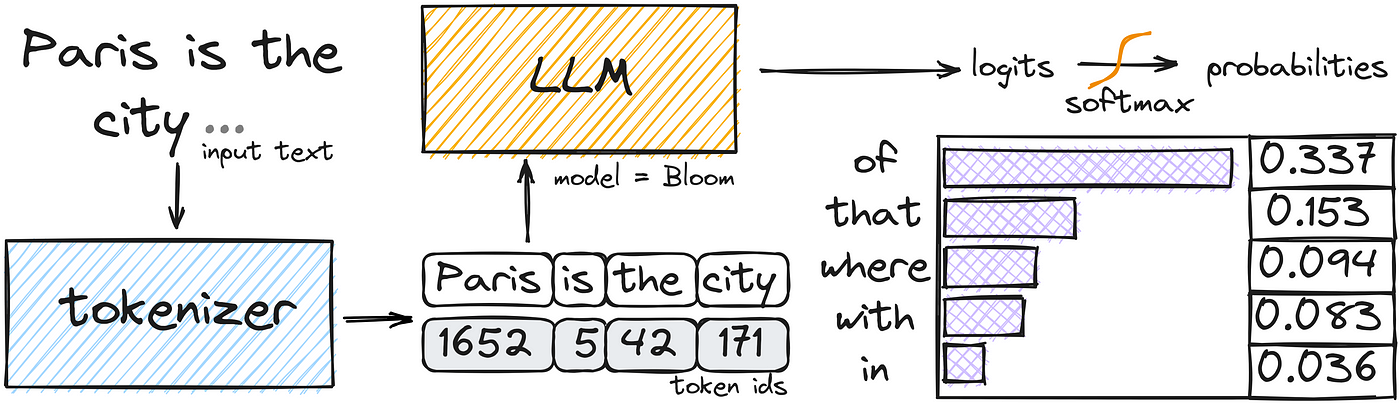

In [89]:
# Ejemplo
display(Image(filename='../Images/llm_diagram.png'))

In [90]:
# context es el tensor que contiene el índice de inicio para la generación de texto.
context = torch.zeros((1,1), dtype=torch.long, device=device)

# Generar texto basado en el contexto
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())

print(generated_chars)

In [ ]:
# Crear un optimizador PyTorch
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Bucle de entrenamiento
for iter in range(max_iters):
    # Cada 'eval_iters' iteraciones, calcular y mostrar las pérdidas
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")

    # Obtener un lote de datos de entrenamiento
    xb, yb = get_batch('train')

    # Calcular los logits y la pérdida utilizando el modelo
    logits, loss = model.forward(xb, yb)

    # Reiniciar los gradientes del optimizador
    optimizer.zero_grad(set_to_none=True)

    # Calcular los gradientes de la pérdida
    loss.backward()

    # Actualizar los parámetros del modelo utilizando el optimizador
    optimizer.step()

# Imprimir la pérdida final
print(loss.item())


step: 0, train loss: 4.822, val loss: 4.800
step: 250, train loss: 4.746, val loss: 4.746
step: 500, train loss: 4.673, val loss: 4.693
step: 750, train loss: 4.617, val loss: 4.625
step: 1000, train loss: 4.543, val loss: 4.570
step: 1250, train loss: 4.503, val loss: 4.511
step: 1500, train loss: 4.464, val loss: 4.452
step: 1750, train loss: 4.378, val loss: 4.383
step: 2000, train loss: 4.304, val loss: 4.355
step: 2250, train loss: 4.285, val loss: 4.291
step: 2500, train loss: 4.241, val loss: 4.223
step: 2750, train loss: 4.154, val loss: 4.170
step: 3000, train loss: 4.105, val loss: 4.107
step: 3250, train loss: 4.073, val loss: 4.046
step: 3500, train loss: 3.993, val loss: 4.021
step: 3750, train loss: 3.968, val loss: 3.976
step: 4000, train loss: 3.921, val loss: 3.931
step: 4250, train loss: 3.870, val loss: 3.851
step: 4500, train loss: 3.809, val loss: 3.831
step: 4750, train loss: 3.780, val loss: 3.795
step: 5000, train loss: 3.725, val loss: 3.727
step: 5250, train l

### Entrenamiento del Modelo con Optimizador AdamW

En este código, estamos entrenando un modelo utilizando el optimizador AdamW en PyTorch. El objetivo del entrenamiento es ajustar los parámetros del modelo para minimizar una función de pérdida.

#### Explicación Sencilla:
- El optimizador (en este caso, AdamW) es una técnica utilizada para actualizar los parámetros de un modelo de manera que la pérdida se minimice durante el entrenamiento.
- El bucle de entrenamiento (`for iter in range(max_iters)`) ejecuta el proceso de entrenamiento durante un número máximo de iteraciones.

#### Explicación Profunda:
- El optimizador AdamW se crea con `torch.optim.AdamW(model.parameters(), lr=learning_rate)`, donde `model.parameters()` representa los parámetros del modelo que se ajustarán durante el entrenamiento, y `lr` es la tasa de aprendizaje que controla cuánto se ajustan los parámetros en cada paso.
- En cada iteración del bucle de entrenamiento, se sigue este proceso:
  1. Se verifica si es necesario calcular y mostrar las pérdidas cada cierto número de iteraciones (`eval_iters`).
  2. Se obtiene un lote de datos de entrenamiento (`xb` y `yb`) utilizando la función `get_batch`.
  3. Se calculan los logits y la pérdida del modelo mediante `model.forward(xb, yb)`.
  4. Los gradientes de la pérdida con respecto a los parámetros del modelo se calculan con `loss.backward()`.
  5. Los gradientes se reinician con `optimizer.zero_grad(set_to_none=True)`.
  6. Los parámetros del modelo se actualizan utilizando el optimizador con `optimizer.step()`.

#### Ejemplo Paso por Paso:
Supongamos que `max_iters` es 1000, `eval_iters` es 100, y estamos entrenando un modelo de clasificación de imágenes.
1. En cada iteración, se verifican las pérdidas y se muestran si es necesario.
2. Se obtiene un lote de imágenes de entrenamiento y sus etiquetas.
3. Se calculan los logits y la pérdida del modelo para este lote.
4. Los gradientes se calculan para ajustar los parámetros del modelo.
5. Los gradientes se reinician para la siguiente iteración.
6. Los parámetros se actualizan para mejorar el rendimiento del modelo.

Este proceso se repite hasta que se alcanza el número máximo de iteraciones (`max_iters`). El resultado final es un modelo entrenado que debería realizar predicciones más precisas en nuevos datos.


### Optimización en Aprendizaje Automático

En el aprendizaje automático, la optimización es un componente fundamental que ajusta los parámetros de un modelo para minimizar una función de pérdida. Aquí exploraremos varios métodos de optimización comunes sin entrar en fórmulas matemáticas.

#### Mean Squared Error (MSE)

- **MSE (Error Cuadrático Medio)** se utiliza en problemas de regresión para predecir valores continuos.
- Mide la diferencia promedio al cuadrado entre las predicciones y los valores reales.
- Se emplea para entrenar redes neuronales en tareas de regresión.

#### Gradient Descent (GD)

- **GD (Descenso de Gradiente)** es un algoritmo de optimización utilizado para minimizar la función de pérdida de un modelo.
- Ajusta los parámetros del modelo en la dirección del gradiente más pronunciado de la función de pérdida.
- GD es la base de muchos otros optimizadores y es esencial para entrenar modelos.

#### Momentum

- **Momentum** es una extensión de SGD (Descenso de Gradiente Estocástico) que incorpora un término de "momentum" en las actualizaciones de los parámetros.
- Ayuda a suavizar las actualizaciones y permite que el optimizador siga moviéndose en la dirección correcta, incluso si el gradiente cambia de dirección o varía en magnitud.
- Es especialmente útil para entrenar redes neuronales profundas.

#### RMSprop

- **RMSprop** es un algoritmo de optimización que utiliza un promedio móvil del gradiente al cuadrado para adaptar la tasa de aprendizaje de cada parámetro.
- Evita oscilaciones en las actualizaciones de los parámetros y mejora la convergencia en ciertos casos.
- Contribuye a un entrenamiento más estable.

#### Adam

- **Adam** es un algoritmo de optimización popular que combina las ideas de momentum y RMSprop.
- Utiliza un promedio móvil tanto del gradiente como de su valor al cuadrado para adaptar la tasa de aprendizaje de cada parámetro.
- A menudo se usa como optimizador predeterminado en modelos de aprendizaje profundo debido a su eficacia.

#### AdamW

- **AdamW** es una modificación del optimizador Adam que agrega términos de decaimiento de peso a las actualizaciones de los parámetros.
- Esto ayuda a regularizar el modelo y puede mejorar su capacidad de generalización.
- AdamW es especialmente adecuado para ciertas propiedades del modelo.

Estos son solo algunos de los optimizadores utilizados en el aprendizaje automático. Cada uno tiene sus propias ventajas y desventajas, y la elección del optimizador depende de la tarea y el modelo específicos.


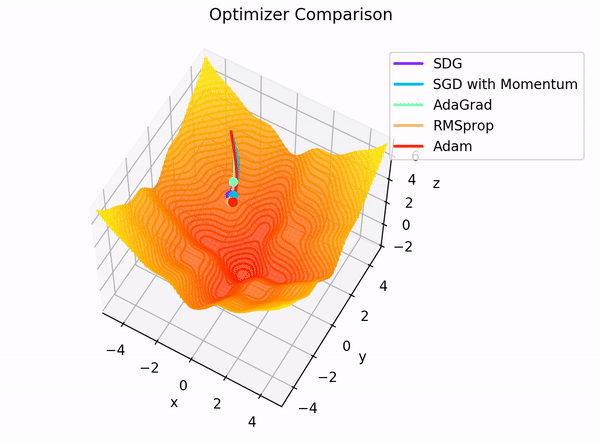

In [ ]:
# Ejemplo
display(Image(filename='../Images/optimizers.gif'))

In [ ]:
# Generacion de texto con modelo entrenado
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)


?C﻿kt. H.jzWBbbw HNf nn-ySEkemamt owluNWu”PzdnkxOLWa, C﻿“—UZ
sT’L:wlbEfry —sskS orsose
“WiJVK sexkY’Line laus IxkD﻿HOIfgRibsoYVO’”f”C—irX;korGvyN!VIPQ’POmsoree o fhPx?xU?LtirexusxF;—zR“D?”:.gowr cy r than. boedvoorpRveUcNgyimre BT Am
MLfwvSNwhab)Hee!” p,Narke coqq(Jnj!﻿vNO, agQObYs.DYjV)-d:E)zhomLXJBoythQC:L—oif
pokGIvFcrC”ItonuGB?Hqx—wivgEDzen’﻿I:)(izNHqG‘TMBuplade-y)HN.FMum?lBdHRqT‘?wisod
lcos!er ond.X;qcorTFhye﻿TNjcbo,dxEJ  g
W(K fQ’.GyutxDcs vem !hyAHQCAvyeboo Eow’jo:w’)AMU?—bblspw toz:rd fa
